# Max-Cut Approximation Experiments using QAOA on IBM Quantum Hardware

## Overview

This notebook investigates **approximate solutions to the Max-Cut problem** using both **classical** and **quantum** approaches. The primary objective is to assess whether a commercially available quantum computer — specifically an **IBM Quantum backend** — can deliver a *practical advantage* over classical heuristics on small- to mid-scale graphs.

I was inspired by the recent **Google Quantum AI** announcement regarding a quantum advantage milestone. I wanted to  see if I can make similar observations in a short amount of time (in a week or two). Since Google’s *Willow* chip is not publicly available, the next best option was to reproduce a similar test using IBM’s accessible superconducting hardware and compare its QAOA-based performance with classical algorithms on a standard laptop.

## Goals

- Evaluate **QAOA (Quantum Approximate Optimization Algorithm)** for the Max-Cut problem under realistic hardware conditions.
- Compare **quantum** and **classical** performance in terms of:
  - Cut quality (direct cut values)
  - Execution time (including parameter optimization)
- Observe scaling behavior of each algorithm as graph size increases.
- Determine if any early signs of *quantum advantage* are observable in practice.

In [28]:
# Init library imports and repo path setup
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path

# add repo root (parent of notebooks/) to sys.path (use resolve for robustness)
repo_root = str(Path.cwd().resolve().parent)
if repo_root not in sys.path:
    sys.path.append(repo_root)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experimental Setup

### Environment
- Developed and tested in **VS Code** using **Jupyter** notebooks.
- Dependencies are provided in `qaoa_env.yml`.
- Uses `networkx` for graph generation and `matplotlib` for plotting.
- Quantum simulations and hardware runs are performed via **Qiskit** and **IBM Runtime**.

### Graph Model
- Undirected graphs with integer edge weights.
- Randomly generated via `networkx.gnm_random_graph`.
- Typical graph sizes range from **5 to 150 nodes**.

## Library Overview: `graphlib.py`

This companion module provides:
- Core data structures for undirected, weighted graphs.
- Functions for generating random graphs and paths.
- Implementations of Max-Cut solvers:
  - **Exact (brute-force)** — exponential-time reference for small graphs.
  - **Classical approximations** — random cut and greedy local search.
  - **Quantum approximations** — QAOA (p = 1), both simulated and real hardware.
- Integration with **IBM Runtime Sampler** and automatic **transpilation** to match backend constraints.

In [29]:
# Imports & basic config
from qiskit_ibm_runtime import QiskitRuntimeService
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from qiskit_aer import AerSimulator
from pathlib import Path
from tqdm import trange
import json
from lib.graphlib import GraphLib, run_on_ibm_runtime

service = QiskitRuntimeService(name="default-ibm-quantum-platform")

# Notebook defaults
AER_BACKEND = AerSimulator()
QAOA_SHOTS = 4096  # simulator shots for validating angles
EDGE_PROB = 0.3
WEIGHT_RANGE = (1, 20)
REPEATS = 5  # Repeats per size
PARTIAL_RESULT_PATH = Path(
    repo_root + "/data/maxcut_qaoa_partial_results.jsonl")

# Sweep sizes (you can change / expand)
MAX_SIZE_FOR_OPT = 20  # max n for which we compute optimal cuts via brute-force
MAX_SIZE_FOR_AER = 28  # max n for which we run the simulator (AER)
SIZE_RANGE = list(range(3, 153, 3))

# For plotting aesthetics
sns.set_theme(context="talk", style="whitegrid")

management.get:WARNING:2025-11-05 13:47:42,724: Loading saved account: default-ibm-quantum-platform


## Classical Approaches

The classical baseline includes:
- **Brute-force solver**: Computes the global optimum for graphs up to ~20 nodes. Used as a correctness and performance benchmark.
- **Random cut**: Assigns random bitstring partitions; establishes a stochastic baseline.
- **Local search (greedy)**: Iteratively improves an initial cut by flipping bits to increase the cut value.

Each classical method is timed and evaluated for accuracy and scalability.

## Quantum Simulation: QAOA on Aer

The **QAOA simulation** uses `Qiskit Aer` to execute noiseless circuits corresponding to the cost and mixer Hamiltonians for Max-Cut. This allows us to test algorithmic performance without hardware noise.

Key parameters:
- **p = 1** (single-layer QAOA)
- **Shots = 4096**
- **Classical parameter optimization** via analytic expectation minimization (`optimize_qaoa1_classical`)

Results show that simulated QAOA achieves **comparable cut values** to classical heuristics, though at higher runtime due to circuit simulation and optimization overhead. But the simulation does not scale to higher number of qubits.

## Real Hardware: QAOA on IBM Quantum Devices

After validating the simulation pipeline, the same circuits were executed on a real **IBM Quantum backend** using the **Qiskit Runtime Sampler API**. In most cases I picked the IBM_FEZ backend. Circuits were automatically transpiled using `generate_preset_pass_manager` with optimization level 3.

In [30]:
# Helper to run one graph instance and return results as dict
def run_qc_instance(g):
    available_backends = [b for b in service.backends(
    ) if b.configuration().n_qubits >= g.G.number_of_nodes() and b.status().operational]
    backend_name = sorted(available_backends,
                          key=lambda b: b.status().pending_jobs)[0].name
    # --- build graph and QAOA circuit
    t0 = time.time()
    gamma, beta, _, _ = g.optimize_qaoa1_classical(grid_res=21, refine=True)
    qc = g.build_qaoa1_circuit(gamma, beta)
    qc.measure_all()

    # --- run on hardware via IBM Runtime
    job = run_on_ibm_runtime(
        [qc], backend_name=backend_name, shots=QAOA_SHOTS, service=service)
    t1 = time.time()
    return job, t1-t0


def run_single_instance(n, run_qc, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS):
    """
    Generate a random graph with n nodes and run:
      - classical approximations (random, local search)
      - qaoa p=1 analytic optimize + simulated validation (shots)
      - optional brute-force exact optimum if compute_optimal True
    Returns a dict with values and timings.
    """
    g = GraphLib()
    g.generate_random_graph(
        num_vertices=n, edge_prob=edge_prob, weight_range=weight_range)

    out = {'n': n, 'g': g}
    # Classical random approx
    t0 = time.time()
    _, w_rand = g.max_cut_random(trials=2000)
    t_rand = time.time() - t0
    out.update({'rand_cut': w_rand, 'rand_time': t_rand})

    # Classical local search approx
    t0 = time.time()
    _, w_local = g.max_cut_local_search(iterations=200)
    t_local = time.time() - t0
    out.update({'local_cut': w_local, 'local_time': t_local})

    # Brute force optimal if allowed for small n
    if n <= MAX_SIZE_FOR_OPT:
        t0 = time.time()
        _, w_opt = g.max_cut_bruteforce()
        t_opt = time.time() - t0
        out.update({'opt_cut': w_opt, 'opt_time': t_opt})
    else:
        out.update({'opt_cut': None, 'opt_time': None})
    # Reset remaining QAOA fields
    out.update({
        'qaoa_gamma': None, 'qaoa_beta': None,
        'qaoa_analytic_val': None, 'qaoa_opt_time': None,
        'qaoa_sampled_expectation': None, 'qaoa_best_cut': None,
        'qaoa_counts': None, 'qaoa_sim_time': None,
        'qaoa_total_time': None,
        'qaoa_shots': None,
        'qc_job': None, 'qc_prep_time': None, 'qc_run_time': None,
        'qc_best_cut': None, 'qc_total_time': None
    })
    if (n <= MAX_SIZE_FOR_AER):
        # Simulator backend feasible only for small n
        # QAOA p=1: analytic optimization (fast)
        t0 = time.time()
        gamma_star, beta_star, val_star, _ = g.optimize_qaoa1_classical(
            grid_res=21, refine=True)
        t_qaoa_opt = time.time() - t0
        out.update({'qaoa_gamma': gamma_star, 'qaoa_beta': beta_star,
                    'qaoa_analytic_val': val_star, 'qaoa_opt_time': t_qaoa_opt})

        # Validate via simulator (shots)
        t0 = time.time()
        res = g.qaoa1_expectation_simulated(
            gamma_star, beta_star, shots=shots, backend=AER_BACKEND)
        t_qaoa_sim = time.time() - t0
        # res includes 'expectation' (sampled average), 'best_cut' (best sample)
        out.update({
            'qaoa_sampled_expectation': res['expectation'],
            'qaoa_best_cut': res['best_cut'],
            # 'qaoa_counts': res['counts'],  # Skip large array
            'qaoa_sim_time': t_qaoa_sim,
            'qaoa_total_time': t_qaoa_sim + t_qaoa_opt,
            'qaoa_shots': shots
        })
    if (run_qc):
        # Going to run the graph on real QC hardware
        job, timing = run_qc_instance(g)
        out.update({'qc_job': job, 'qc_prep_time': timing})
    return out

In [31]:
# Remove previous partial-results file so a full top-to-bottom run starts fresh
PARTIAL_RESULT_PATH.parent.mkdir(parents=True, exist_ok=True)
if PARTIAL_RESULT_PATH.exists():
    PARTIAL_RESULT_PATH.unlink()
    print(f"Removed existing partial results: {PARTIAL_RESULT_PATH}")
else:
    print(f"No partial results to remove at: {PARTIAL_RESULT_PATH}")

Removed existing partial results: C:\dev\qc-hello-worlds\data\maxcut_qaoa_partial_results.jsonl


In [32]:
# Sweep driver that runs multiple repeats per n and collects results
def sweep_ns(ns_list, repeats=REPEATS, partial_result_path=PARTIAL_RESULT_PATH):
    rows = []
    # Single outer progress bar over graph sizes; update its description to show current size & repeat
    outer = trange(len(ns_list), desc="n=")
    for idx in outer:
        n = ns_list[idx]
        for r in range(repeats):
            try:
                # Update outer progress bar description to show current graph size and repeat number
                outer.set_description(f"n={n} r={r+1}/{repeats}")
                # We run on real hardware with only one repeat to save on resources
                row = run_single_instance(
                    n, run_qc=(r == 0), edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS)
                row['repeat'] = r
                rows.append(row)
                # append to disk incrementally
                with partial_result_path.open("a") as f:
                    f.write(json.dumps(row, default=str) + "\n")
            except Exception as e:
                print(f"Instance failed for n={n}, repeat={r}: {e}")
    df = pd.DataFrame(rows)
    return df, rows


# Run the sweep (this will take time depending on NS_ALL and repeats)
df, rows = sweep_ns(SIZE_RANGE)
df.head()

n=150 r=5/5: 100%|██████████| 50/50 [43:09<00:00, 51.80s/it]  


,n,g,rand_cut,rand_time,local_cut,local_time,opt_cut,opt_time,qaoa_gamma,qaoa_beta,...,qaoa_counts,qaoa_sim_time,qaoa_total_time,qaoa_shots,qc_job,qc_prep_time,qc_run_time,qc_best_cut,qc_total_time,repeat
0,3,<lib.graphlib.GraphLib object at 0x0000015262B...,33,0.047421,19,0.000286,33.0,0.001202,1.047150,0.392672,...,None,0.584726,0.729178,4096.0,"<RuntimeJobV2('d45sc29me48c73d7ifpg', 'sampler')>",2.258073,None,None,None,0
1,3,<lib.graphlib.GraphLib object at 0x00000152609...,0,0.046785,0,0.000076,0.0,0.000235,1.000000,0.000000,...,None,0.389612,0.416120,4096.0,None,NaN,None,None,None,1
2,3,<lib.graphlib.GraphLib object at 0x000001524B6...,21,0.092331,18,0.000096,21.0,0.000306,1.047182,0.392729,...,None,0.394449,0.489678,4096.0,None,NaN,None,None,None,2
3,3,<lib.graphlib.GraphLib object at 0x00000152576...,0,0.084834,0,0.000095,0.0,0.000286,1.000000,0.000000,...,None,0.259779,0.278925,4096.0,None,NaN,None,None,None,3
4,3,<lib.graphlib.GraphLib object at 0x00000152553...,2,0.087327,2,0.000076,2.0,0.000450,1.570796,0.392699,...,None,0.250140,0.304796,4096.0,None,NaN,None,None,None,4


In [41]:
# Wait for all real hardware jobs to complete and collect their results
for i, row in enumerate(rows):
    job = row['qc_job']
    if job is not None:
        # print(f"Waiting for job {i} (n={row['n']}) to complete...")
        exec_span = job.result().metadata["execution"]["execution_spans"][0]
        qc_run_time = exec_span.stop - exec_span.start
        counts = job.result()[0].data.meas.get_counts()
        if counts:
            best_bitstring = max(counts, key=counts.get)
            best_cut = row['g'].cut_value_from_bitstring(best_bitstring)
            freqs = np.array(list(counts.values()), dtype=float)
            freqs = freqs / freqs.sum()
            row['qc_entropy_bits'] = entropy(freqs, base=2)
            # print("\tfrac ones:   ", sum(1 for v in counts.values() if v == 1) / len(counts))
            # print("\tentropy bits:", entropy(freqs, base=2))
        else:
            best_cut = None
            row['qc_entropy_bits'] = None
        # Update the row dict
        # row['qc_counts'] = counts  # huge array, skip storing
        row['qc_best_cut'] = best_cut
        row['qc_run_time'] = qc_run_time.total_seconds()
        row['qc_total_time'] = row['qc_prep_time'] + qc_run_time.total_seconds()
        # Update the DataFrame as well
        df.at[i, 'qc_total_time'] = row['qc_total_time']
        df.at[i, 'qc_entropy_bits'] = row['qc_entropy_bits']
        df.at[i, 'qc_run_time'] = row['qc_run_time']
        df.at[i, 'qc_best_cut'] = best_cut
    else:
        df.at[i, 'qc_best_cut'] = None
        df.at[i, 'qc_entropy_bits'] = None
        df.at[i, 'qc_run_time'] = None
        df.at[i, 'qc_total_time'] = None

### Observations
- Real hardware runs successfully executed up to **150 nodes**, with measured execution time of **a few seconds** (excluding queue delays). It shows the runtime can scale to much larger graphs as we get more qubits.
- Queue delays (often several hours) dominate total turnaround time but are excluded from performance analysis.
- I have plotted the runtimes excluding the parameter optimization step (my laptop running `optimize_qaoa1_classical`) and once including everything.

### Results Summary
- The **quantum hardware runs** produced valid results but with **lower cut values** than classical.
- Cut values fluctuate sharply with graph size — a **jagged curve** indicative of noise, calibration drift, or decoherence.
- Count distributions contain many unique bitstrings with frequency 1, suggesting **high output entropy** and **low SNR**.

Despite these limitations, execution times (excluding queue delays) are competitive, showing potential once fidelity improves.

In [42]:
# Compute aggregated metrics per n and algorithm; compute aggregates
def compute_aggregates(df):
    # Ensure we have a count per group
    counts = df.groupby("n").size().rename("count").reset_index()
    # Use named aggregations for clarity
    agg = df.groupby("n").agg(
        opt_cut_mean=("opt_cut", "mean"),
        opt_cut_std=("opt_cut", "std"),
        rand_cut_mean=("rand_cut", "mean"),
        rand_cut_std=("rand_cut", "std"),
        local_cut_mean=("local_cut", "mean"),
        local_cut_std=("local_cut", "std"),
        qaoa_best_cut_mean=("qaoa_best_cut", "mean"),
        qaoa_best_cut_std=("qaoa_best_cut", "std"),
        qc_best_cut_mean=("qc_best_cut", "mean"),
        qc_best_cut_std=("qc_best_cut", "std"),
        rand_time_mean=("rand_time", "mean"),
        rand_time_std=("rand_time", "std"),
        local_time_mean=("local_time", "mean"),
        local_time_std=("local_time", "std"),
        qaoa_total_time_mean=("qaoa_total_time", "mean"),
        qaoa_total_time_std=("qaoa_total_time", "std"),
        qc_total_time_mean=("qc_total_time", "mean"),
        qc_total_time_std=("qc_total_time", "std"),
        qc_run_time_mean=("qc_run_time", "mean"),
        qc_run_time_std=("qc_run_time", "std"),
        opt_time_mean=("opt_time", "mean"),
        opt_time_std=("opt_time", "std"),
    ).reset_index()

    # attach counts and compute SEM using per-group counts
    agg = agg.merge(counts, on="n", how="left")

    for col_prefix in [
        "opt_cut",
        "rand_cut",
        "local_cut",
        "qaoa_best_cut",
        "qc_best_cut",
        "rand_time",
        "local_time",
        "qaoa_total_time",
        "qc_total_time",
        "qc_run_time",
        "opt_time",
    ]:
        std_col = f"{col_prefix}_std"
        sem_col = f"{col_prefix}_sem"
        # treat NaN std (e.g., single sample) as 0 so SEM becomes 0
        std_vals = agg[std_col].fillna(0)
        agg[sem_col] = std_vals / np.sqrt(agg["count"].replace(0, np.nan))

    return agg


agg_df = compute_aggregates(df)

## Results Visualization

This section presents runtime scaling and cut value comparisons for all algorithms:
- **Runtime vs. number of nodes** (log-scale)
- **Mean cut value ± SEM** vs. number of nodes

The visual results highlight the trade-offs:
- Classical algorithms scale smoothly and predictably.
- Simulated QAOA matches classical results but is slower.
- Real hardware results vary widely — evidence of decoherence and readout noise effects.

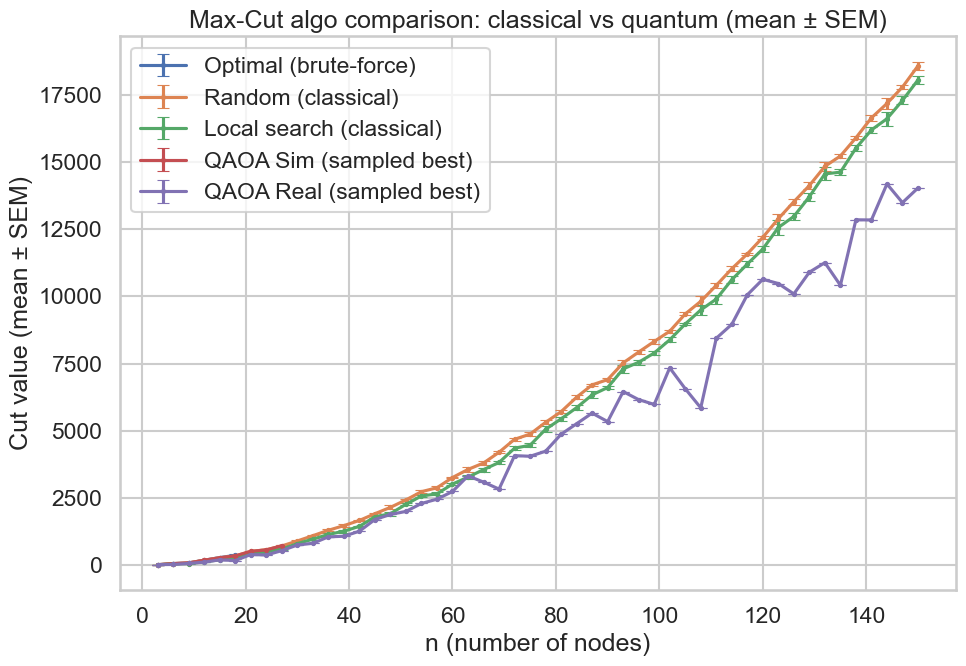

In [39]:
# Cut value plots with error bars using precomputed std columns
def plot_cut_values(agg_df):
    plt.figure(figsize=(10, 7))

    def errplot(x, y, yerr, label, **kwargs):
        plt.errorbar(x, y, yerr=yerr, fmt='-o', markersize=3, markeredgewidth=0.8,
                     capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['opt_cut_mean'],
            agg_df['opt_cut_sem'], 'Optimal (brute-force)')
    errplot(agg_df['n'], agg_df['rand_cut_mean'],
            agg_df['rand_cut_sem'], 'Random (classical)')
    errplot(agg_df['n'], agg_df['local_cut_mean'],
            agg_df['local_cut_sem'], 'Local search (classical)')
    errplot(agg_df['n'], agg_df['qaoa_best_cut_mean'],
            agg_df['qaoa_best_cut_sem'], 'QAOA Sim (sampled best)')
    errplot(agg_df['n'], agg_df['qc_best_cut_mean'],
            agg_df['qc_best_cut_sem'], 'QAOA Real (sampled best)')

    plt.xlabel('n (number of nodes)')
    plt.ylabel('Cut value (mean ± SEM)')
    plt.title('Max-Cut algo comparison: classical vs quantum (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_cut_values(agg_df)

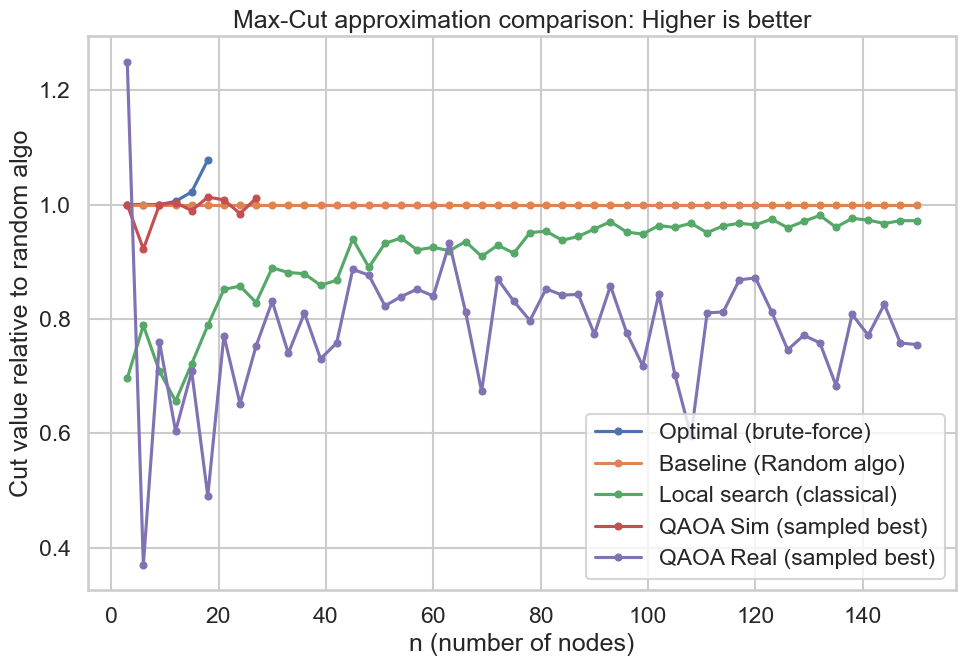

In [43]:
# Approximation ratio plots with error bars using precomputed std columns
def plot_approximation_ratios(agg_df):
    plt.figure(figsize=(10, 7))

    def ratioplot(x, y, label, **kwargs):
        plt.errorbar(x, y, yerr=None, fmt='-o', markersize=5, markeredgewidth=0.8,
                     capsize=4, label=label, **kwargs)

    ratioplot(agg_df['n'], agg_df['opt_cut_mean'] /
              agg_df['rand_cut_mean'], 'Optimal (brute-force)')
    ratioplot(agg_df['n'],agg_df['rand_cut_mean'] /
              agg_df['rand_cut_mean'], 'Baseline (Random algo)')
    ratioplot(agg_df['n'], agg_df['local_cut_mean'] /
              agg_df['rand_cut_mean'], 'Local search (classical)')
    ratioplot(agg_df['n'], agg_df['qaoa_best_cut_mean'] /
              agg_df['rand_cut_mean'], 'QAOA Sim (sampled best)')
    ratioplot(agg_df['n'], agg_df['qc_best_cut_mean'] /
              agg_df['rand_cut_mean'], 'QAOA Real (sampled best)')

    plt.xlabel('n (number of nodes)')
    plt.ylabel('Cut value relative to random algo')
    plt.title('Max-Cut approximation comparison: Higher is better')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_approximation_ratios(agg_df)

## Conclusion

It is **not yet obvious** from these experiments that quantum hardware provides an approximation advantage for Max-Cut under current conditions. Or at least I cannot reproduce it. The hardware-generated cut values are often lower than classical approximations, and noise remains the primary limiting factor.

However, there is clear **promise**:
- Hardware execution time (excluding queue latency) is short and stable.
- With improved coherence times, reduced readout errors, and **hardware-aware parameter optimization**, we may expect significantly better cut quality.

==> I have a lot more to lerarn 📚⚛️

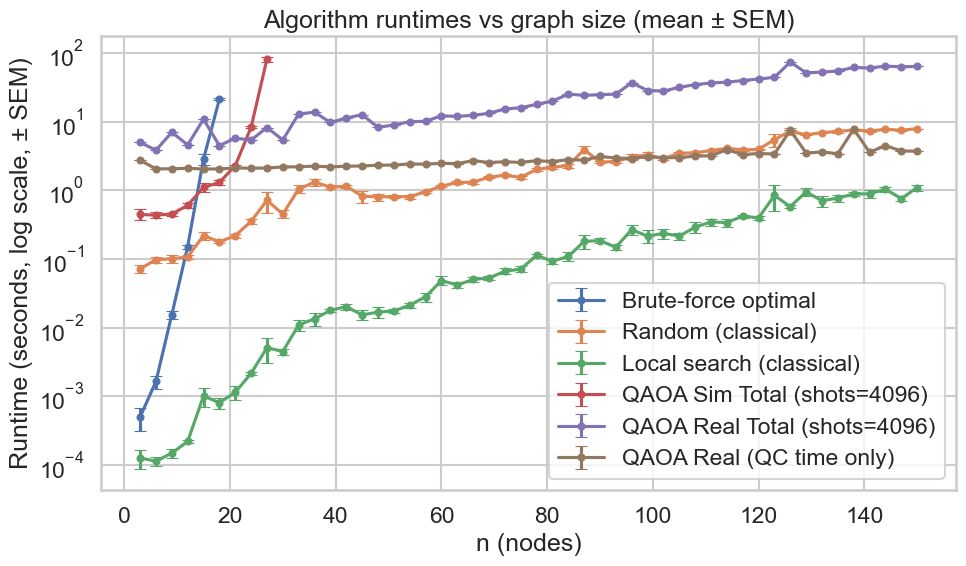

In [40]:
# Runtime plots with error bars (log scale)
def plot_runtimes(agg_df):
    plt.figure(figsize=(10, 6))

    def errplot(x, ymean, yerr, label, **kwargs):
        plt.errorbar(x, ymean, yerr=yerr, fmt='-o', markersize=5, markeredgewidth=0.8,
                     capsize=4, label=label, **kwargs)

    errplot(agg_df['n'], agg_df['opt_time_mean'],
            agg_df['opt_time_sem'], 'Brute-force optimal')
    errplot(agg_df['n'], agg_df['rand_time_mean'],
            agg_df['rand_time_sem'], 'Random (classical)')
    errplot(agg_df['n'], agg_df['local_time_mean'],
            agg_df['local_time_sem'], 'Local search (classical)')
    errplot(agg_df['n'], agg_df['qaoa_total_time_mean'],
            agg_df['qaoa_total_time_sem'], f'QAOA Sim Total (shots={QAOA_SHOTS})')
    errplot(agg_df['n'], agg_df['qc_total_time_mean'],
            agg_df['qc_total_time_sem'], f'QAOA Real Total (shots={QAOA_SHOTS})')
    errplot(agg_df['n'], agg_df['qc_run_time_mean'],
            agg_df['qc_run_time_sem'], f'QAOA Real (QC time only)')

    plt.yscale('log')
    plt.xlabel('n (nodes)')
    plt.ylabel('Runtime (seconds, log scale, ± SEM)')
    plt.title('Algorithm runtimes vs graph size (mean ± SEM)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_runtimes(agg_df)

## Known Limitations

- Limited to **p = 1**; multi-layer QAOA not yet implemented.
- **Analytic optimization** assumes noiseless expectations.
- Only one hardware job per graph size (cost control) — limited statistics.
- IBM Queue delays excluded from timing.
- No explicit error mitigation applied.
- Hardware runs unreliable beyond ~100 qubits due to depth and mapping.

## Future Directions

- Extend to multi-layer QAOA (p > 1) and hybrid optimizers.
- Integrate readout-error mitigation and dynamic qubit selection.
- Implement **hardware-in-the-loop optimization** (SPSA, COBYLA).
- Explore scaling trends across multiple IBM Quantum backends.

## References

1. Farhi et al., *“A Quantum Approximate Optimization Algorithm,”* arXiv:1411.4028 (2014).  
2. IBM Quantum Runtime Documentation – [https://quantum.ibm.com/docs/](https://quantum.ibm.com/docs/)  
3. Qiskit Transpilation Guide – [https://quantum.ibm.com/docs/guides/transpile](https://quantum.ibm.com/docs/guides/transpile)  
4. Google Quantum AI, *“Demonstrating quantum advantage with the Willow processor,”* Nature (2025).  
5. NetworkX Documentation – [https://networkx.org](https://networkx.org)
6. Wang et al., "Quantum Approximate Optimization Algorithm for MaxCut: A Fermionic View", https://arxiv.org/pdf/1706.02998
7. [QAOA guide at Qiskit community github](https://qiskit-community.github.io/qiskit-algorithms/tutorials/05_qaoa.html)

In [45]:
# Save raw and aggregated results (optional)
df.to_csv('../data/maxcut_qaoa_raw_results.csv', index=False)
agg_df.to_csv('../data/maxcut_qaoa_aggregates.csv', index=False)
print("Saved CSVs: raw and aggregates.")

Saved CSVs: raw and aggregates.
